[![badge](https://img.shields.io/badge/launch-notebook-E66581.svg?logo=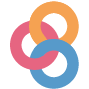)](https://mybinder.org/v2/gl/nu-data-insights%2Fquantum/HEAD?filepath=docs%2Fscc-intro.ipynb)

!!! quote "[Richard Feynman](http://www.cs.berkeley.edu/~christos/classics/Feynman.pdf)"
    _Nature isn't classical, dammit, and if you want to make a simulation of nature, you'd better make it quantum mechanical, and by golly it's a wonderful problem, because it doesn't look so easy._


Welcome to our first {++Quantum Information++} tutorial! The aim is to teach you how a data-science project can be made {==Quantum Ready==} with this hands on example project.

![image_0](images/quantum-mechanics-1525470_1280.jpg)


We are going to see how to handle {==Quantum Data==}. And then use {==Hybrid-Quantum-Machine-Learning==} i.e. Classical-Machine-Learning applied to the data.



!!! tip "What you will learn!"
    * How to build quantum algorithm from quantum data and logical operations with `cirq`
    * How to learn quantum data and control the output using `tensorflow-quantum`
    * How this data-science project can be organised and pipelines/workflows created using `metaflow`
___

## The Background

In some near-future world, there is a company, The Schrödinger Cat Company (SCC), who have a quantum data problem that needs solving...

They have made a device that puts cats to sleep. It can also can wake them up again, since they are an ethical company (despite having a business that is about messing with the conciousness of cats...).



## The Data

They're going to use `cirq` to write and control the algorithmns for their _device_, so to begin with, we can import the modules that we need:

In [2]:
import cirq
from cirq.contrib.svg import SVGCircuit

### One Cat

Define a qubit that will represent a lone cat.

In [3]:
cat = cirq.GridQubit(0,0)

We will use that notation that $|0\rangle$ means the cat is awake, and $|1\rangle$ means the cat is asleep.

Using a qubit, starting in the state $|0\rangle$, a simple quantum circuit can be made to change the state of the cat:

$$
X = \begin{bmatrix}
0 & 1 \\
1 & 0 
\end{bmatrix}
$$

Such that:

$$
\begin{align}
X |0\rangle &= |1\rangle \\
X |1\rangle &= |0\rangle
\end{align}
$$

Writing this using `python` and `cirq` we can define our first basic algorithm that is switching a cat from being awake to being asleep:

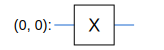

In [4]:
circuit = cirq.Circuit(cirq.X(cat))
SVGCircuit(circuit)

Using some convience functions in `cirq` we can quickly simulate the circuit and check what the final state (state of the qubit at the end of the circuit) is:

In [5]:
cirq.dirac_notation(cirq.Simulator()\
                    .simulate(circuit)\
                    .final_state)

'|1⟩'

We can use the power of quantum mechanics to put the cat in the superposition state of $\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle$ ), meaning the cat is both asleep and awake. If it was to be then observed at this point, it would be found to be awake or asleep with equal probabilities. 

Such a state can be controled via a quantum-gate operation $H$

In [6]:
cirq.dirac_notation(cirq.Simulator()
                    .simulate(
                              cirq.Circuit( [ cirq.H(cat) ] )
                    )
                    .final_state)

'0.71|0⟩ + 0.71|1⟩'

!!! note
    Remember that for a state of $\alpha|0\rangle + \beta |1\rangle$, the probability of observing state $|0\rangle$ is $\alpha^2$ and $\beta^2$ for $|1\rangle$, with $\alpha^2 + \beta^2 = 1$


How much the cat is asleep and awake can also be controlled by quantum logic gates. For example, the cat can be put into a state that is 75% awake and 25% asleep:

In [18]:
import numpy as np

circuit = cirq.Circuit([cirq.H(cat)**(0.5)])
result = cirq.Simulator().simulate(circuit)
final_state = result.final_state
np.round(final_state,2)

array([0.85+0.15j, 0.35-0.35j], dtype=complex64)

In 'dirac notation':

In [19]:
cirq.dirac_notation(final_state)

'(0.85+0.15j)|0⟩ + (0.35-0.35j)|1⟩'

Performing some checks of the probability, for a sanity check...

Probability in state $|0\rangle$: 

In [20]:
np.round( np.vdot(final_state[0], final_state[0]), 2)

(0.75+0j)

Probability in state $|1\rangle$: 

In [21]:
np.round( np.vdot(final_state[1], final_state[1]), 2)

(0.25+0j)

Let's check this by running the quantum circuit via a simulator.. In the future, this would be running the code on a QPU (Quantum Processing Unit).

First we have to append a measurement on the qubit, and we can visualise the quantum circuit representation of this:

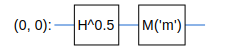

In [23]:
circuit.append(cirq.measure(cat,key='m'))
SVGCircuit(circuit)

Then we can run the circuit 1000 times to produce a histogram of the number of times we observe the cat to be either asleep or awake:

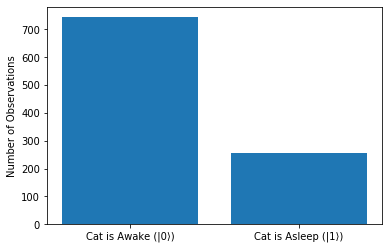

Counter({0: 744, 1: 256})


In [26]:
import matplotlib.pyplot as plt 
simulator = cirq.Simulator()
results = simulator.run(circuit,repetitions=1000)

x = ['Cat is Awake (|0⟩)','Cat is Asleep (|1⟩)']
y = [results.histogram(key='m')[i] for i in range(len(x)) ] 


fig,ax = plt.subplots(1)
ax.set_ylabel('Number of Observations')
ax.bar(x,y)
plt.show();
print (results.histogram(key='m'))

### Two Cats

Suppose there is now two cats:
* $|00\rangle$ means both cats are awake
* $|11\rangle$ means both cats are asleep.
* $|01\rangle$ means the first cat is awake, the second asleep
* $|10\rangle$ means the first cat is asleep, the second awake


We are going to {==entangle==} the cats by putting the first cat into a superposition (H) and then applying a controlled NOT gate (CNOT) to perform the entanglement.

!!! note
    The CNOT gate flips the 2nd qubit if the 1st qubit is `1` and leaves it alone if it is `0`.
    
    
*  Qubits start in the state $|00\rangle$
*  $H$ acting on the 1st qubit makes the state $\frac{1}{\sqrt{2}}(|00\rangle + |10\rangle)$
*  CNOT acting on this state produces the final state $\frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)$
    
The final expected possible measurements are both awake ($|00\rangle$) or both asleep ($|11\rangle$), these are said to be entangled because whatever the observed outcome (awake or asleep) of either cat is, the other must be also be in the same state. In other words, there is zero probability to observe $|01\rangle$ or $|10\rangle$, one cat asleep, one cat awake.

We can test this circuit to verify the outcome of 1000 simulations of this algorithm:

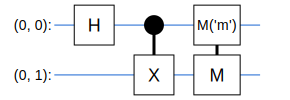

In [27]:
cat1  = cirq.GridQubit(0,0)
cat2  = cirq.GridQubit(0,1)


circuit = cirq.Circuit([
                cirq.H(cat1),
                cirq.CNOT(cat1,cat2),
                cirq.measure(cat1,cat2,key='m')
                ])


SVGCircuit(circuit)

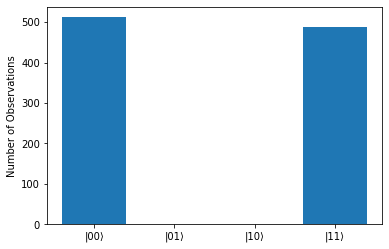

In [28]:
simulator = cirq.Simulator()
results = simulator.run(circuit,repetitions=1000)

x = ['|00⟩','|01⟩','|10⟩','|11⟩']
y = [results.histogram(key='m')[i] for i in range(len(x)) ] 


fig,ax = plt.subplots(1)

ax.set_ylabel('Number of Observations')
ax.bar(x,y)
plt.show();

As can be seen, we have a observed approximately (due to the random nature) 50:50 the scenarios where both cats are asleep or both cats are awake.